In [7]:
using Statistics
using Printf
using Plots
using LinearAlgebra

using DelimitedFiles

using Base.Threads

In [8]:
function compute_pcf(xs, ys, xi_ar, dxi; Lx::Float64=maximum(xs) - minimum(xs), Ly::Float64=maximum(ys) - minimum(ys))

    N = length(xs)
    nb = length(xi_ar)
    counts_t = zeros(Float64, nb, nthreads())

    r_min = xi_ar[1] - dxi / 2
    r_max = xi_ar[end] + dxi / 2
    r0 = xi_ar[1] - dxi / 2

    @threads :static for i in 1:N-1
        xi = xs[i]
        yi = ys[i]
        tid = min(threadid(), nthreads())
        for j in i+1:N
            dx = xs[j] - xi
            dy = ys[j] - yi

            # Apply periodic boundary conditions
            dx -= Lx * round(dx / Lx)
            dy -= Ly * round(dy / Ly)

            r = hypot(dx, dy)
            if (r >= r_min) && (r < r_max)
                k = Int(floor((r - r0) / dxi)) + 1
                if 1 <= k <= nb
                    # println("Thread $(threadid()) counting pair (i=$i, j=$j) at distance r=$r into bin k=$k")
                    counts_t[k, tid] += 2.0  # *2 for ordered pairs
                end
            end
        end
    end

    counts = sum(counts_t; dims=2)[:]
    pcf = similar(counts)
    area = Lx * Ly
    pair_factor = N * (N - 1)
    area_pref = 2π * dxi / area

    @inbounds for k in 1:nb
        r = xi_ar[k]
        den = pair_factor * (area_pref * r)
        pcf[k] = den > 0 ? counts[k] / den : NaN
    end

    return pcf
end

compute_pcf (generic function with 1 method)

# Horshoe bend PCF

In [ ]:
input_path = "Data/horseshoe_bend_example_coordinates.txt"  # coordinates file

coords, header = readdlm(input_path, header=true)

xs = coords[:, 1]
ys = coords[:, 2]

r_max = 100.0  # maximum radius to consider
dr = 2.5       # radial bin width

L = 1000.0  # box size

# Radial bins
r_ar = collect(dr/2:dr:r_max)

# Compute PCF
g = compute_pcf(xs, ys, r_ar, dr; Lx=L, Ly=L)

# Save output 
open("Data/horseshoe_bend_pcf.csv", "w") do io
    println(io, "r,g")
    @inbounds for k in 1:length(r_ar)
        @printf(io, "%.6f,%.6f\n", r_ar[k], g[k])
    end
end

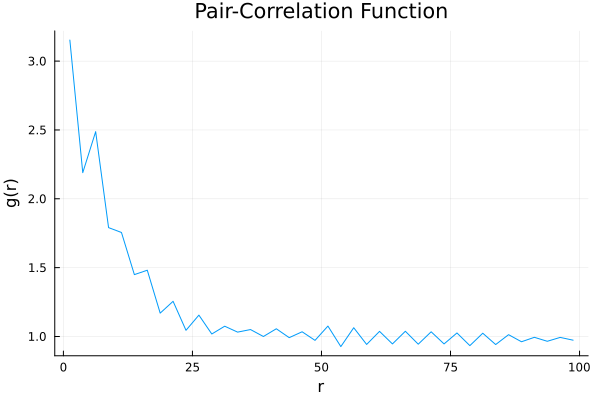

In [10]:
plot(r_ar, g, xlabel="r", ylabel="g(r)", title="Pair-Correlation Function", legend=false)

# Big system simulation

In [5]:
input_path = "Data/big_simulation_example_coordinates.txt"  # coordinates file

coords = readdlm(input_path)

xs = coords[1, :]
ys = coords[2, :]

r_max = 10.0  # maximum radius to consider
dr = 0.2       # radial bin width

L = 100.0  # box size

# Radial bins
r_ar = collect(dr/2:dr:r_max)

# Compute PCF
g = compute_pcf(xs, ys, r_ar, dr; Lx=L, Ly=L)

# Save output
open("Data/big_simulation_pcf.csv", "w") do io
    println(io, "r,g")
    @inbounds for k in 1:length(r_ar)
        @printf(io, "%.6f,%.6f\n", r_ar[k], g[k])
    end
end

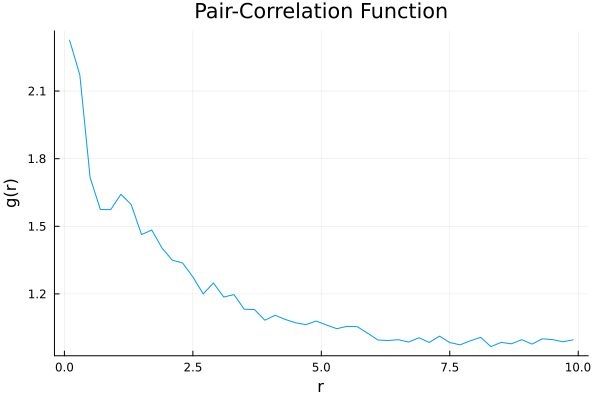

In [6]:
plot(r_ar, g, xlabel="r", ylabel="g(r)", title="Pair-Correlation Function", legend=false)